# Steam Data Analysis with Python

## Introduction

Many of the commonly heard of games come from big AAA developers, who have the resources to heavily fund the development and marketing of their titles. These games are often jam-packed with action, high quality graphics, and a fast and rewarding playstyle. It is for this reason that games like Stardew Valley stand out so much from the crowd. Stardew Valley is a popular independent, or indie, game that was developed mostly by a single person over the course of 4 years. The game has managed to reach critical and commercial success with over 10 million copies sold, while maintaining the exact opposite playstyle compared to that of most AAA games. At its core, Stardew Valley is a slow paced farming simulator with RPG elements and pixel art graphics.

So how likely is this level of success for an indie game? Is it rare to find indie titles among the top selling games on Steam? How do ratings for indie games compare to that of AAA games? Are indie games becoming more popular in the industry, and why might that be the case? This project aims to answer all these questions and more, in order to gain a better understanding of the role independent developers play in the gaming industry.

The information used in this project was collected via web scraping Steam, which is permitted by their robots.txt file. We will be analyzing data regarding the top 100 selling games, based on gross revenue, on Steam for 2017, 2018, and 2019. The data was collected on 3/9/2020 from Steam's end-of-year list of top selling games for 2017, 2018, and 2019:
* https://store.steampowered.com/sale/2017_best_sellers/
* https://store.steampowered.com/sale/winter2018bestof/
* https://store.steampowered.com/sale/2019_top_sellers/

## Importing Libraries and Setting Up

The `selenium`, `requests`, `time`, `bs4`, `re`, and `pandas` libraries are needed to properly scrape the data into a DataFrame and clean the resulting DataFrame. The `numpy` and `scipy` libraries are used for analysis, while `matplotlib` and `seaborn` are used for visualization.

In [1]:
from selenium import webdriver
import requests
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

After importing the necessary modules, we can begin to scrape the data into a Pandas DataFrame.

In [2]:
urls = {2017: 'https://store.steampowered.com/sale/2017_best_sellers/',
        2018: 'https://store.steampowered.com/sale/winter2018bestof/',
        2019: 'https://store.steampowered.com/sale/2019_top_sellers'}
lst = []

for i in range(2017, 2020):
    # Selenium is used here since these pages use Javascript
    driver = webdriver.Chrome('C:\Chromedriver\chromedriver.exe')
    driver.get(urls[i])
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()
    
    columns = ['year', 'ranking', 'title', 'genres', 'tags', 'rating', 'num_reviews']
    year = i
    table = []
    
    divs = soup.find_all('div',\
                         attrs={'class': 'partnersaledisplay_SaleSection_1cOoC eventbbcodeparser_SaleSectionCtn_39HWX'})
    # Try and except statements necessary due to different HTML for different years
    if divs == []:
        divs = soup.find_all('div', attrs={'class': 'sale_tier'})
    for div in divs:
        try:
            ranking = div.find(attrs={'div', 'partnereventshared_SaleSectionHeader_2WMiQ'}).text
        except AttributeError:
            ranking = div.h2.text
            
        if ranking != '':
            games = div.find_all('a')
            for game in games:
                game_url = game['href']
                # Cookies necessary to bypass age verification
                source = requests.get(game_url, cookies={'birthtime': '691574401'}).content
                time.sleep(1)
                game_page = BeautifulSoup(source, 'html.parser')

                title = game_page.find('div', attrs={'class': 'apphub_AppName'}).text

                genres = []
                genre_links = game_page.find('div',\
                                        attrs={'class': 'block responsive_apppage_details_left game_details underlined_links'})\
                                       .find('div', attrs={'class': 'details_block'}).find_all('a')
                for genre_link in genre_links:
                    if 'genre' in str(genre_link):
                        genres.append(genre_link.string)

                tags = []
                tag_links = game_page.find('div', attrs={'class': 'glance_tags popular_tags'}).find_all('a')
                for tag_link in tag_links:
                    tags.append(tag_link.string.strip())

                try:
                    rating_num_reviews = game_page.find('div', attrs={'itemprop': 'aggregateRating'})\
                                                  .find('span',attrs={'class': 'nonresponsive_hidden responsive_reviewdesc'})\
                                                  .get_text('|')
                    rating_num_reviews_split = re.split('(\d+)', rating_num_reviews.strip().replace(',', ''))
                    rating = int(rating_num_reviews_split[1])
                    num_reviews = int(rating_num_reviews_split[3])
                except AttributeError:
                    rating = 0
                    num_reviews = 0

                row = [year, ranking, title, genres, tags, rating, num_reviews]
                table.append(row)
                
    lst.append(pd.DataFrame(table, columns=columns))
    
df = pd.concat(lst).reset_index(drop=True)

## Overview of the Data

Now that we have the raw data, we can now begin modifying and analyzing the data. First, we will create a column `is_indie` that is `True` if "Indie" is marked as a genre or tag for that game, and `False` otherwise. This will allow us to quickly select for indie games during our analysis.

In [3]:
df['is_indie'] = df.apply(lambda row: True if ('Indie' in row['genres'] or 'Indie' in row['tags']) else False, axis=1)
df

,year,ranking,title,genres,tags,rating,num_reviews,is_indie
0,2017,Platinum,ARK: Survival Evolved,"[Action, Adventure, Indie, Massively Multiplay...","[Open World Survival Craft, Survival, Open Wor...",75,232401,True
1,2017,Platinum,PLAYERUNKNOWN'S BATTLEGROUNDS,"[Action, Adventure, Massively Multiplayer]","[Survival, Shooter, Multiplayer, Battle Royale...",52,1144468,False
2,2017,Platinum,Rocket League®,"[Action, Indie, Racing, Sports]","[Multiplayer, Soccer, Competitive, Sports, Rac...",92,277234,True
3,2017,Platinum,Z1 Battle Royale,"[Action, Adventure, Free to Play, Massively Mu...","[Survival, Massively Multiplayer, Multiplayer,...",55,208623,False
4,2017,Platinum,Dota 2,"[Action, Free to Play, Strategy]","[Free to Play, MOBA, Multiplayer, Strategy, eS...",85,1240035,False
...,...,...,...,...,...,...,...,...
294,2019,Bronze,Two Point Hospital,"[Indie, Simulation]","[Medical Sim, Simulation, Management, Building...",90,11558,True
295,2019,Bronze,Yu-Gi-Oh! Duel Links,"[Free to Play, Strategy]","[Free to Play, Card Game, Strategy, Anime, Mul...",81,18713,False
296,2019,Bronze,RimWorld,"[Indie, Simulation, Strategy]","[Colony Sim, Base Building, Survival, Strategy...",98,54112,True
297,2019,Bronze,Mortal Kombat 11,[Action],"[Fighting, Gore, Violent, Blood, Multiplayer, ...",78,17386,False


We should note here that the ratings and number of reviews for each title represents only their current value as of the date of data collection, they do not represent the values as they were in 2017, 2018, or 2019. This is because the values were scraped from the official game store pages, and past data is not readily available from Steam.

## Deverloper Composition of Top Selling Games

Let's determine just how uncommon it is for an indie game to be represented as one of Steam's top selling games. Due to their increased funding, we expect AAA developers to vastly outnumber indie developers when it comes to top selling games. We will use data from all three years and determine how many total games are made by indie developers versus AAA developers.

In [4]:
df.is_indie.value_counts().reset_index().rename(columns={'index': 'is_indie', 'is_indie': 'counts'})

,is_indie,counts
0,False,215
1,True,84


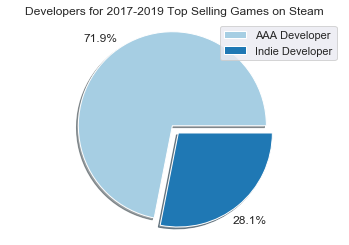

In [5]:
sns.set(style='darkgrid', palette='Paired')
fig, ax = plt.subplots()
ax.pie(df.is_indie.value_counts(), autopct='%0.1f%%', pctdistance=1.2, shadow=True, explode=(0, 0.1))
ax.legend(['AAA Developer', 'Indie Developer'])
ax.set_title('Developers for 2017-2019 Top Selling Games on Steam')
ax.axis('equal')
plt.show()

Indie games actually cover 28.1% of the top market, which is quite a significant chunk of the pie! Despite their more limited resources, indie developers seem quite capable of producing top selling games.

## Analysis of Ratings

Next we will compare the ratings of top selling indie games to that of AAA games to see if one is typically more well-received than the other. Just like before, we will be using data from all three years that Steam has provided.

In [6]:
df.groupby('is_indie').rating.mean().reset_index()

,is_indie,rating
0,False,80.269767
1,True,90.023810


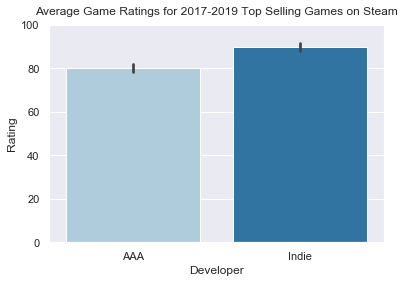

In [7]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='is_indie', y='rating')
ax.set_xlabel('Developer')
ax.set_xticklabels(['AAA', 'Indie'])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel('Rating')
ax.set_title('Average Game Ratings for 2017-2019 Top Selling Games on Steam', pad=10)
plt.show()

In [8]:
indie_games = df[df.is_indie == True]
AAA_games = df[df.is_indie == False]

print("The standard deviation of ratings for indie games is {0}".format(np.std(indie_games.rating)))
print("The standard deviation of ratings for AAA games is {0}".format(np.std(AAA_games.rating)))

The standard deviation of ratings for indie games is 8.359448874628537
The standard deviation of ratings for AAA games is 14.010021909312101


Indie games are rated almost a full 10% higher than AAA games on average! They also have a smaller standard deviation, showing less variation in ratings.

Now that we know indie games are typically rated higher than AAA games, let's see how the "indie" genre is rated compared to other genres such as action or adventure. To do this, each title's genres are given a score equal to the title's score. The genres are then grouped together and the average rating is calculated for each genre. In this analysis, genres with counts lower than 10 are dropped to avoid skewing the data with possible outliers.

In [9]:
genre_counts = df.explode('genres').groupby('genres').title.count().reset_index().rename(columns={'title': 'counts'})
genre_ratings = df.explode('genres').groupby('genres').rating.mean().reset_index()

genre_counts_ratings = pd.merge(genre_counts, genre_ratings).sort_values(by='rating', ascending=False)
genre_counts_ratings = genre_counts_ratings[genre_counts_ratings.counts >= 10].reset_index(drop=True)
genre_counts_ratings

,genres,counts,rating
0,Indie,70,91.471429
1,Early Access,10,90.200000
2,Strategy,82,84.463415
3,Free to Play,34,83.970588
4,RPG,82,83.926829
5,Simulation,91,83.285714
6,Action,174,82.091954
7,Adventure,94,81.702128
8,Massively Multiplayer,36,75.638889
9,Sports,15,64.733333


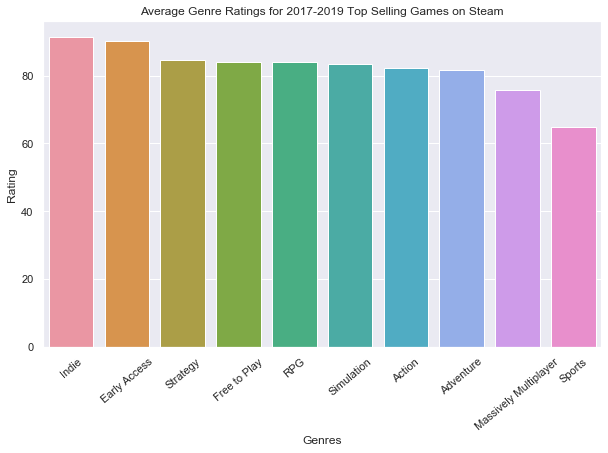

In [10]:
sns.set(style='darkgrid', palette='husl')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=genre_counts_ratings, x='genres', y='rating')
plt.xticks(rotation=40)
ax.set_xlabel('Genres')
ax.set_ylabel('Rating')
ax.set_title('Average Genre Ratings for 2017-2019 Top Selling Games on Steam')
plt.show()

In [11]:
print("The average genre rating is: {0}".format(genre_counts_ratings.rating.mean()))

The average genre rating is: 82.14842788996613


The "indie" genre is the rated highest, with an amazing average rating of 91.5, which is almost 10 points higher than the average of 82.1. Note that this average rating for the "indie" genre is different from the previous average rating for indie games, because some games are tagged as "indie" without having "indie" as a genre, and vice versa.

## Comparison Over Time

We now know that indie games can be successful, and are rated on average much better than AAA developer games or other genres. Are they becoming more popular and increasing their hold on the market as one might suspect?

In [12]:
indie_counts = df.groupby(['year', 'is_indie']).title.count().reset_index().rename(columns={'title': 'counts'})
year_counts = df.groupby('year').title.count().reset_index().rename(columns={'title': 'year_counts'})
indie_year_counts = pd.merge(indie_counts, year_counts)
indie_year_counts['percentage'] = indie_year_counts.counts / indie_year_counts.year_counts
indie_year_counts

,year,is_indie,counts,year_counts,percentage
0,2017,False,71,99,0.717172
1,2017,True,28,99,0.282828
2,2018,False,73,100,0.730000
3,2018,True,27,100,0.270000
4,2019,False,71,100,0.710000
5,2019,True,29,100,0.290000


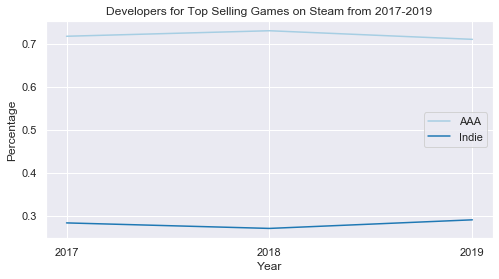

In [13]:
sns.set(style='darkgrid', palette='Paired')
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=indie_year_counts, x='year', y='percentage', hue='is_indie')
ax.set_xticks([2017, 2018, 2019])
ax.legend(['AAA', 'Indie'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Developers for Top Selling Games on Steam from 2017-2019')
plt.show()

According to the graph, it doesn't look like much has changed over the past three years. The developer composition for top selling games appears stagnant. Let's run a chi squared test to check.

In [14]:
X = [[71, 28],
     [73, 27],
     [71, 29]]

chi2, pval, dof, expected = stats.chi2_contingency(X)
print("The p-value is {0}".format(pval))

The p-value is 0.9504560943428806


With a p-value of 0.95, we cannot reject the null hypothesis that there is no significant difference between the datasets.

It does not appear that indie games are increasing their hold on the top 100 selling games on Steam. Could one of the reasons be because they make less than AAA games, and some developers may not find it worthwhile to go up against these companies? To see if indie games typically make less than AAA games, we will group them by which "ranking" they fall in. Steam has categorized the top selling games based on a "Platinum", "Gold", "Silver", or "Bronze" ranking system, which represents how much revenue each game has brought in. 

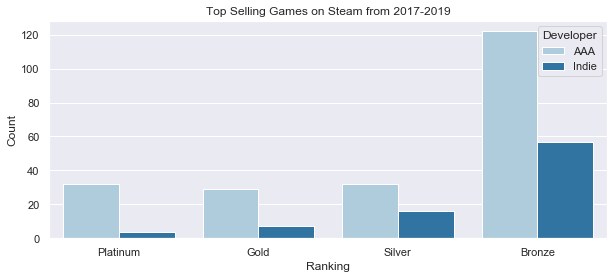

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=df, x='ranking', y='rating', hue='is_indie', estimator=len)
ax.set_xlabel('Ranking')
ax.set_ylabel('Count')
ax.set_title('Top Selling Games on Steam from 2017-2019')
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['AAA', 'Indie'], title="Developer")
plt.show()

Indie games make up a very small portion of top tier games ("Platinum" and "Gold") and thus generally make less than their AAA counterparts. However this makes sense due to the lower financial support they receive.

## Genre Composition

Lastly, let's see if indie developers focus on different genres than AAA developers. Are AAA developers focused more on a particular subset of genres than indie developers? For this analysis, the "indie" genre has been exluded.

In [16]:
genre_explode = df.explode('genres')
genre_explode_no_indie = genre_explode[genre_explode.genres != 'Indie']
dev_genre_counts = genre_explode_no_indie.groupby(['is_indie', 'genres']).title.count().reset_index()\
                                         .rename(columns={'title': 'counts'})\
                                         .sort_values(by=['is_indie', 'counts'], ascending=[True, False])
AAA_genre_counts = dev_genre_counts[dev_genre_counts.is_indie == False]
indie_genre_counts = dev_genre_counts[dev_genre_counts.is_indie == True]
dev_genre_counts

,is_indie,genres,counts
0,False,Action,134
9,False,Strategy,64
7,False,Simulation,59
5,False,RPG,56
1,False,Adventure,54
3,False,Free to Play,31
4,False,Massively Multiplayer,25
8,False,Sports,12
2,False,Casual,1
6,False,Racing,1


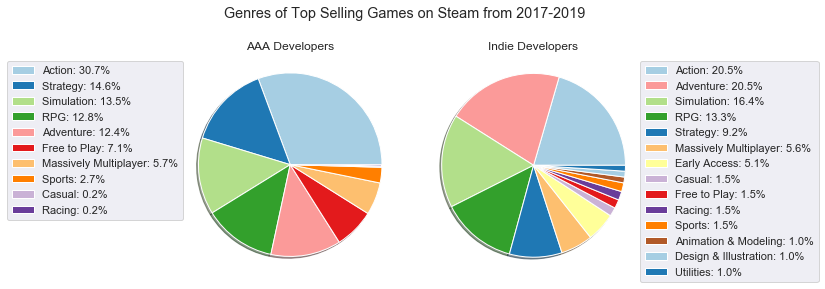

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Genres of Top Selling Games on Steam from 2017-2019', y=1.05)

color_dict = dict(zip(dev_genre_counts.genres.unique(), sns.color_palette('Paired', dev_genre_counts.genres.nunique())))

percentage_1 = 100 * np.array(AAA_genre_counts.counts) / sum(np.array(AAA_genre_counts.counts))
label_1 = ['{0}: {1:0.1f}%'.format(a, b) for (a, b) in zip(AAA_genre_counts.genres, percentage_1)]
ax1.pie(AAA_genre_counts.counts, shadow=True, colors=[color_dict[v] for v in AAA_genre_counts.genres])
ax1.legend(label_1, bbox_to_anchor=(0, 1))
ax1.set_title('AAA Developers')
ax1.axis('equal')

percentage_2 = 100 * np.array(indie_genre_counts.counts) / sum(np.array(indie_genre_counts.counts))
label_2 = ['{0}: {1:0.1f}%'.format(a, b) for (a, b) in zip(indie_genre_counts.genres, percentage_2)]
ax2.pie(indie_genre_counts.counts, shadow=True, colors=[color_dict[v] for v in indie_genre_counts.genres])
ax2.legend(label_2, bbox_to_anchor=(1, 1))
ax2.set_title('Indie Developers')
ax2.axis('equal')

plt.show()

The top selling indie games are more varied in their genre composition than AAA games, with more genres overall and less of an emphasis on action. This supports the stereotype that AAA games are more focused on providing top-tier action, strategy, adventure, and RPG games, while indie games typically cover a wider scope of playstyles.

## Summary and Closing Thoughts

We can see from the data that indie games actually make up a fairly significant portion of top selling games on Steam. They are also typically rated higher than their AAA counterparts, and offer a broader scope of playstyles as well. With this in mind, one might think that indie games may begin to increase their hold on the market. However, the ratio of indie games to AAA games has remained fairly constant in Steam's top selling games over the past three years. We explored one possible reason for this, and determined that AAA games typically have higher gross revenues than indie games, which may be a deterrent for some developers. However, this should be expected due to their ability to spend more on development and marketing. In addition, indie developers are typically smaller than AAA developers, so the revenue they earn may be relatively more than AAA developers when company size is taken into account.

So what other reasons could there be for why indie games are not overtaking the market despite superior ratings and proven success stories? Perhaps it comes down to simple preference, where a large portion of the player population may simply prefer action packed titles with high quality graphics, while a smaller portion of the population may prefer slower paced and relaxing titles. Another possibility is that AAA developers are more likely to offer microtransactions which increase gross revenue significantly, or that their games simply cost more. Ratings may also not matter as much as we may think, with the popularity of games often playing a significant role in their success, which can be affected through marketing. In addition, Steam has only begun providing this data three years ago, which is a fairly short time frame for analysis. Further anlaysis on the topic may be necessary to answer these questions.